In [1]:
from functions2 import *

Running Heuristic algorithm and sanity check

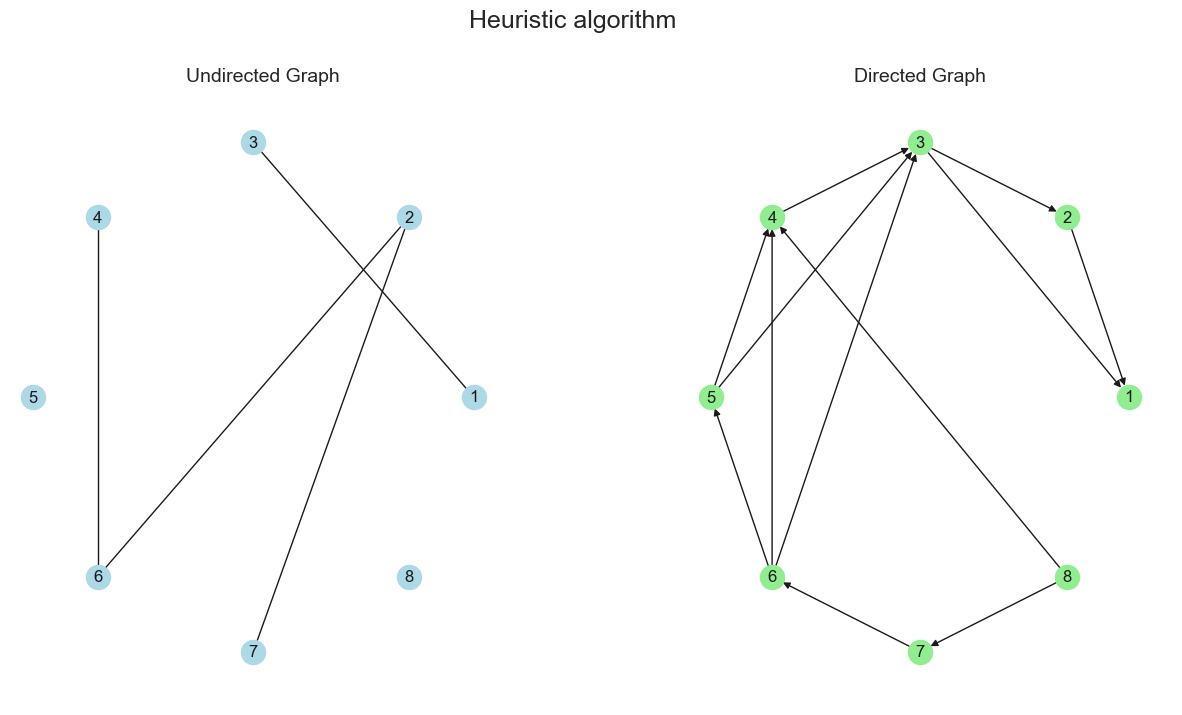

Heuristic intervention set for S={'2', '6', '4'}: --> {'7'}
Maximal hedge for Q[S] after intervention:  {'2', '6', '4'}
Sanity check OK


In [2]:
random.seed(0)
admg = random_ADMG(8,6,4)
admg.draw(title = 'Heuristic algorithm')
S = admg.S_set()

# Find intervention set through Heuristic algorithm
heuristic_set = Heuristic(S,admg.gd,admg.gu,admg.weights)
print('Heuristic intervention set for S={}: --> {}'.format(S,heuristic_set))


gd_test = admg.gd.copy()
gu_test = admg.gu.copy()
parents = set()

# Remove edges from the parents in gd and from the neighbors in gu (intervention)
for node in heuristic_set:
    parents = set(gd_test.predecessors(node))
    neighbors = list(gu_test.neighbors(node))
    for parent in parents:
        gd_test.remove_edge(parent, node)
    for neighbor in neighbors:
        gu_test.remove_edges_from([(node,neighbor),(neighbor,node)])

maximal_hedge = Hhull(S,gd_test,gu_test)
print('Maximal hedge for Q[S] after intervention: ',maximal_hedge)
if maximal_hedge == S:
    print('Sanity check OK')


Simulation for optimal, heuristic and LP solutions

In [3]:
import time
random.seed(0)
found_suboptimal = False

n = 0
# List with number of nodes for each simulation
N_list = list(range(10,201,2))

# Initialize result vectors
exact_t = np.zeros(len(N_list))
heuristic_t = np.zeros(len(N_list))
LP_t = np.zeros(len(N_list))

exact_cost = np.zeros(len(N_list))
heuristic_cost = np.zeros(len(N_list))
LP_cost = np.zeros(len(N_list))

for i in N_list:
    counter = itertools.count(0)
    while True:
        #Change seed if we encounter graph with no intervention needed
        random.seed(next(counter))
        # Create reandom graph 
        admg = random_ADMG(i,2*i,i)
        # Initialize S set using class function
        S = admg.S_set()

        parents = set()
        
        start_time_heuristic = time.time()
        for s in S:
            parents_s = set(admg.gd.predecessors(s))
            parents.update(parents_s)  

        H = Hhull(S,admg.gd,admg.gu)
        H1 = H.intersection(parents-S)
        # Go further only if Q[S] is not identifiable, otherwise generate new graph and check again
        if H1 != set():
            break

    
    # Heuristic algorithm
    heuristic_cost[n],heuristic_set = min_nodes_cut(admg.gu.subgraph(H),source_set=H1,S=S,weights = admg.weights)
    heuristic_t[n] = time.time()-start_time_heuristic

    #Exact algorithm
    start_time_exact = time.time()
    exact_set = MinCostIntervention(S, admg.gd, admg.gu, admg.weights)
    exact_t[n] = time.time()-start_time_exact
    exact_cost[n] = set_weight(exact_set,admg.weights)

    # Linear Programming algorithm
    start_time_LP = time.time()
    LP_set = MinCostIntervention_LP(S, admg.gd, admg.gu, admg.weights)
    LP_t[n] = time.time() - start_time_LP
    LP_cost[n] = set_weight(exact_set,admg.weights)
    
    # Find first suboptimal solution
    if (found_suboptimal == False) and (exact_set != heuristic_set):
        subopt_admg = admg
        found_suboptimal = True

    n += 1


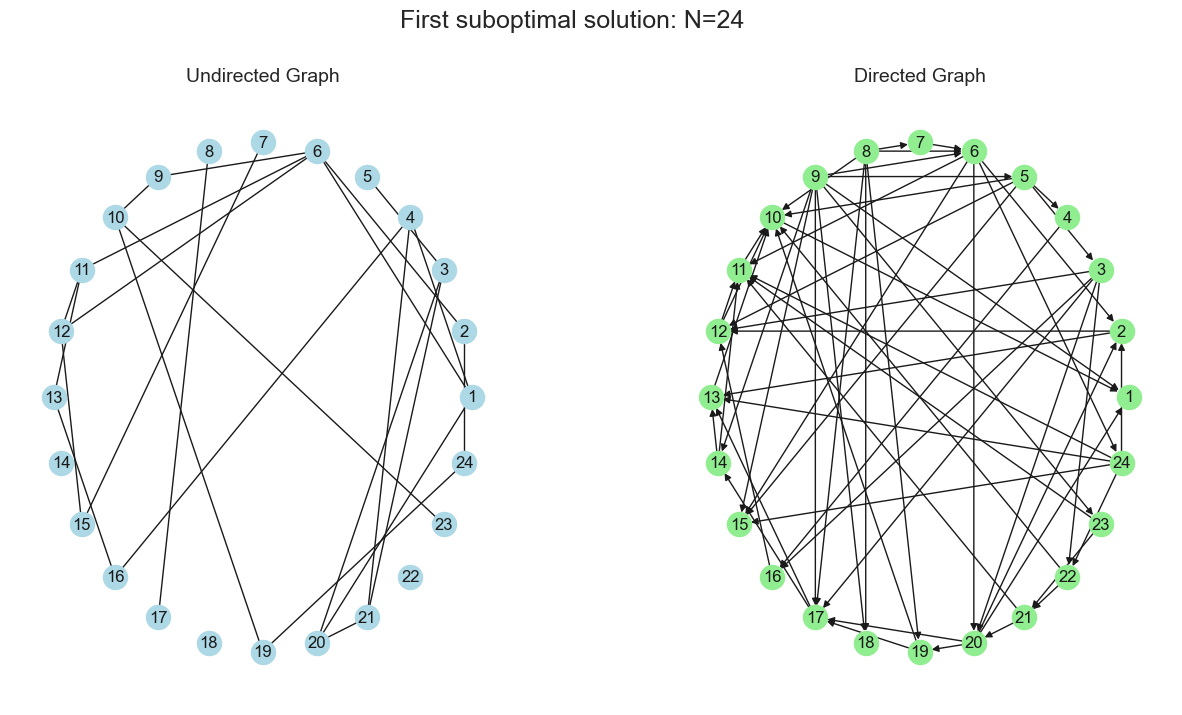

In [4]:
#Show first suboptimal graph
subopt_admg.draw(title = "First suboptimal solution: N={}".format(len(subopt_admg.nodes)))

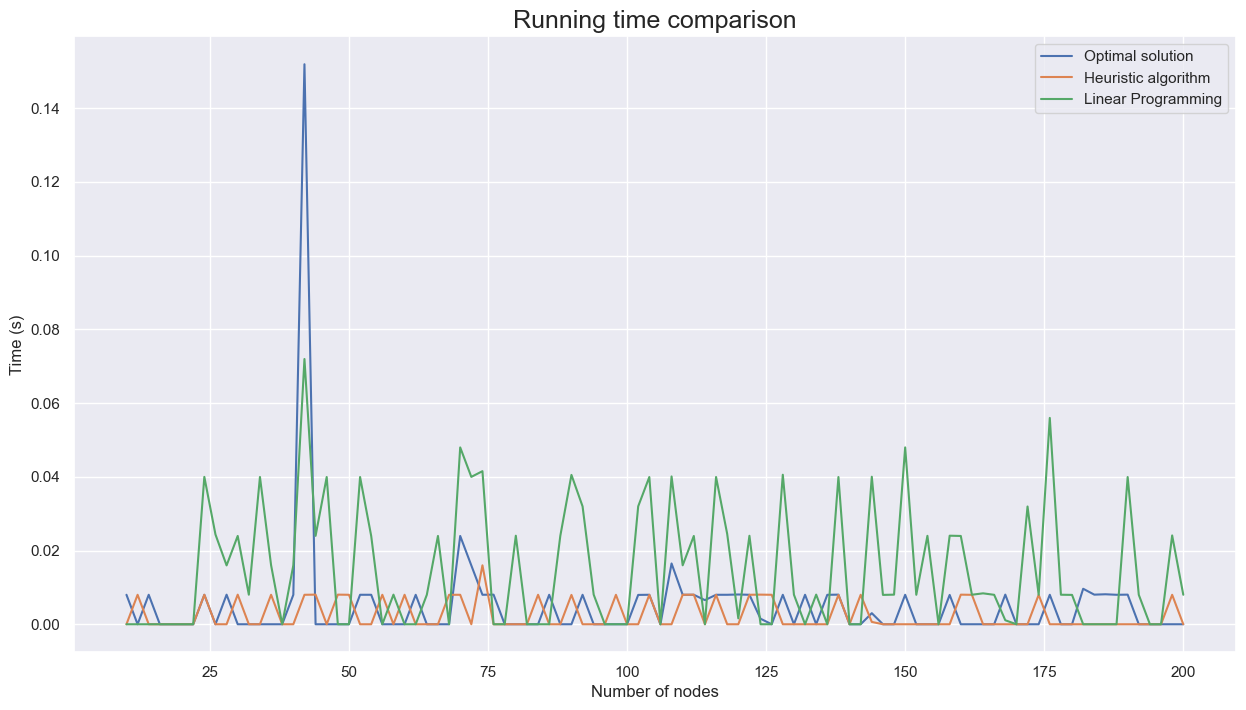

In [5]:
sns.lineplot(x=N_list,y=exact_t, label = 'Optimal solution')
sns.lineplot(x=N_list,y=heuristic_t, label = 'Heuristic algorithm')
sns.lineplot(x=N_list,y=LP_t, label = 'Linear Programming')

plt.title('Running time comparison',size = 18)
plt.xlabel('Number of nodes')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

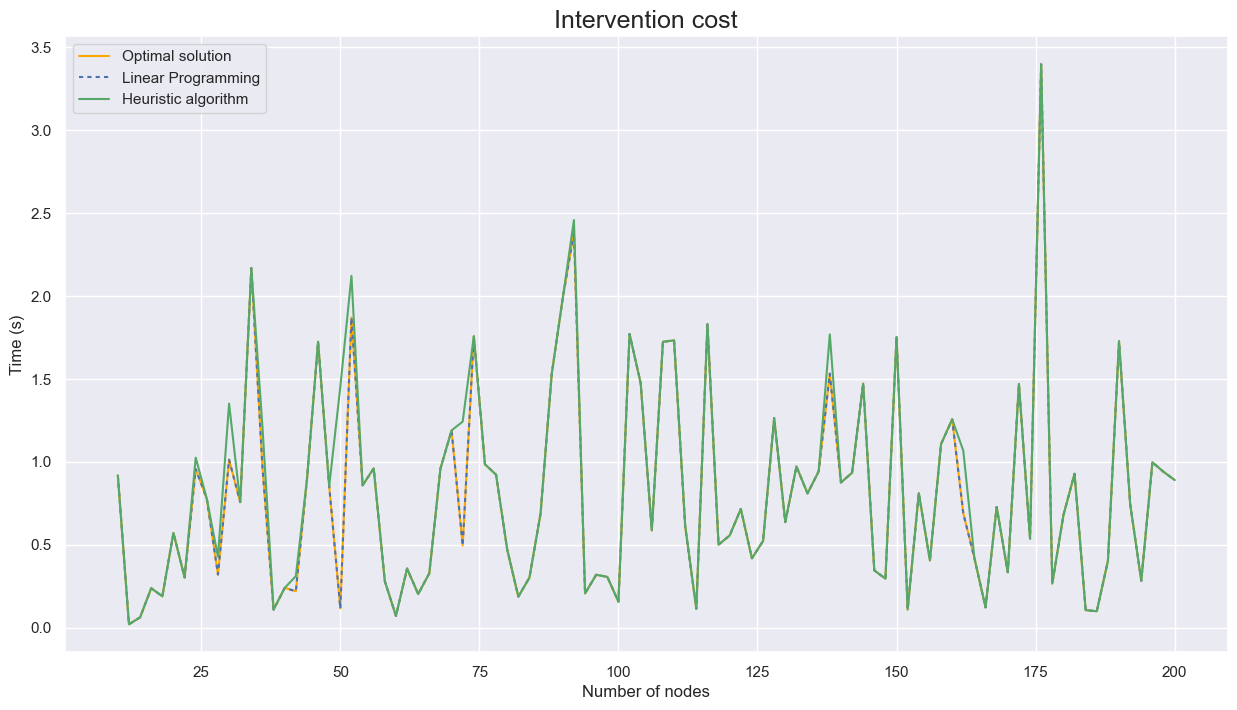

In [6]:
sns.lineplot(x=N_list,y=exact_cost, label = 'Optimal solution',color='orange')
sns.lineplot(x=N_list,y=LP_cost, label = 'Linear Programming',dashes=(2,2),color='b')
sns.lineplot(x=N_list,y=heuristic_cost, label = 'Heuristic algorithm',color='g')

plt.title('Intervention cost',size = 18)
plt.xlabel('Number of nodes')
plt.ylabel('Time (s)')
plt.legend()
plt.show()